In [34]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.utils import save_image

In [35]:
if (os.path.exists("./data")) == False:
    os.mkdir("data")

In [36]:
dir_pokemon = "./archive/pokemon"
files_pokemon = os.listdir(dir_pokemon + '/pokemon')

In [37]:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])


batch_size = 350

device = torch.device("cuda")


dataset = ImageFolder(root = dir_pokemon, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last = True)

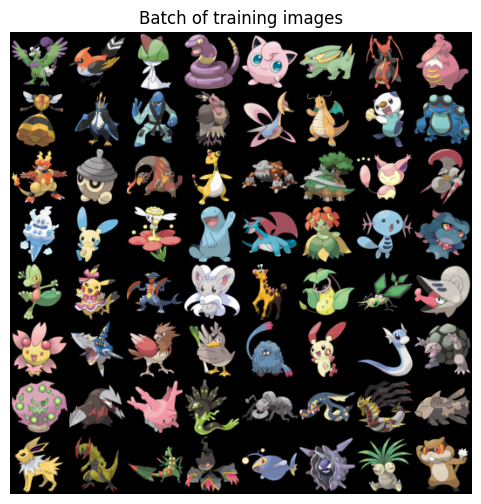

In [38]:
first_batch = next(iter(dataloader))
plt.figure(figsize=(6, 6))
plt.axis("off")
plt.title("Batch of training images")
plt.imshow(vutils.make_grid(first_batch[0][:64], padding=2, normalize=True).cpu().numpy().transpose(1,2,0))
plt.show()

In [39]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator

In [40]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator

In [41]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(1 * 1 * 256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )


    def forward(self, input):
        output = self.main(input)
        output = output.view(-1, 256 * 1 * 1)
        output = self.classifier(output)
        return output

In [42]:
first_batch = next(iter(dataloader))
image, image_label = first_batch[0].to(device), first_batch[1].to(device)

discriminator = Discriminator()
discriminator.to(device)

output = discriminator(image)

print(output.size())

torch.Size([350, 1])


In [43]:
noise = torch.randn(batch_size, 128, 1, 1, device=device)
generator = Generator()
generator.to(device)

fake_image = generator(noise)
print(fake_image.size())

torch.Size([350, 3, 64, 64])


# Train

In [44]:
criterion = nn.BCELoss()

generator = Generator()
discriminator = Discriminator()

generator.apply(weights_init)
discriminator.apply(weights_init)

generator.to(device)
discriminator.to(device)

optimizerD = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 10000

In [45]:
# Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        image, image_label = data[0].to(device), data[1].to(device)

        # Train discriminator
        discriminator.zero_grad()

        label = torch.full((batch_size,), 1, dtype=torch.float, device=device)

        output = discriminator(image).view(-1)

        loss_discriminator_real = criterion(output, label)
        loss_discriminator_real.backward()

        noise = torch.randn(batch_size, 128, 1, 1, device=device)
        fake_image = generator(noise)
        label.fill_(0)

        output = discriminator(fake_image.detach()).view(-1)

        loss_discriminator_fake = criterion(output, label)
        loss_discriminator_fake.backward()

        errD = loss_discriminator_real + loss_discriminator_fake
        optimizerD.step()

        # Train generator
        generator.zero_grad()
        label.fill_(1)
        output = discriminator(fake_image).view(-1)

        loss_generator = criterion(output, label)
        loss_generator.backward()
        optimizerG.step()

    if (epoch % 10 == 0):
        with torch.no_grad():
            fixed_noise = torch.randn(64, 128, 1, 1, device=device)
            fake_images = generator(fixed_noise).detach().cpu()
            loss_on_real = loss_discriminator_real.detach().cpu()
            loss_on_fake = loss_discriminator_fake.detach().cpu()

        print(f'epoch: {epoch}, loss on real: {loss_on_real}, loss on fake: {loss_on_fake}')

        save_image(fake_images, f'./data/fake_images_epoch_{epoch:04d}.png', nrow=8, normalize=True)


epoch: 0, loss on real: 0.6477097868919373, loss on fake: 0.7355120778083801
epoch: 10, loss on real: 0.2836490571498871, loss on fake: 0.8583881258964539
epoch: 20, loss on real: 0.3041294515132904, loss on fake: 0.8126081228256226
epoch: 30, loss on real: 0.4267069399356842, loss on fake: 0.509899914264679
epoch: 40, loss on real: 0.15188680589199066, loss on fake: 1.0070561170578003
epoch: 50, loss on real: 0.39554712176322937, loss on fake: 0.6790100932121277
epoch: 60, loss on real: 0.3585205376148224, loss on fake: 0.6521406173706055
epoch: 70, loss on real: 0.42905256152153015, loss on fake: 0.7741670608520508
epoch: 80, loss on real: 0.5036161541938782, loss on fake: 0.8087300062179565
epoch: 90, loss on real: 0.7078205347061157, loss on fake: 0.6127569675445557
epoch: 100, loss on real: 0.523254930973053, loss on fake: 0.7147032022476196
epoch: 110, loss on real: 0.4302949607372284, loss on fake: 0.6903892159461975
epoch: 120, loss on real: 0.5701267123222351, loss on fake: 0.

KeyboardInterrupt: 